In [1]:
import torch
import torch.optim as optim
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
from laddervae import *
from tqdm.notebook import tqdm

%matplotlib inline

In [2]:
tensor_transform = transforms.ToTensor()

dataset = datasets.MNIST(root="./data",
						 train=True,
						 download=True,
						 transform=tensor_transform)


loader = DataLoader(dataset=dataset,
					batch_size=64,
					shuffle=True,
                    pin_memory=True)

In [3]:
DEVICE = "mps"  # "cuda"  "cpu"

model = LadderVAE().to(DEVICE)
optimizer = optim.Adam(model.parameters())
loss_function = nn.MSELoss()

In [4]:
model.train()
torch.autograd.set_detect_anomaly(True)
epochs = 3  # 3 epochs is mostly enough for this specific model
outputs = []
losses = []

beta = 1e-04

for epoch in range(epochs):
    model.train()

    with tqdm(loader, unit="it") as loop:
        loop.set_description(f"Epoch {epoch + 1}/{epochs}")
        for (image, _) in loop:
            image = image.to(DEVICE)
            #image_ = corrupt(image, device=DEVICE)
            reconstructed, kld_loss = model(image)
    
            loss = model.recon_loss(reconstructed, image, p=2) + beta * kld_loss
            
            optimizer.zero_grad()
            loss.backward()
            _loss_value = loss.item()
            optimizer.step()
            del loss
            model.flush()
            loop.set_postfix(loss=_loss_value / len(loader))
            beta *= 1.001 if beta < 0.5 else 1  # WU regularization
    
            # Storing the losses in a list for plotting
            losses.append(_loss_value)
            
    print('Epoch: %03d/%03d || Loss: %.4f'% (epoch+1, epochs, _loss_value))

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch: 001/003 || Loss: 34.4638


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch: 002/003 || Loss: 35.5179


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch: 003/003 || Loss: 33.0548


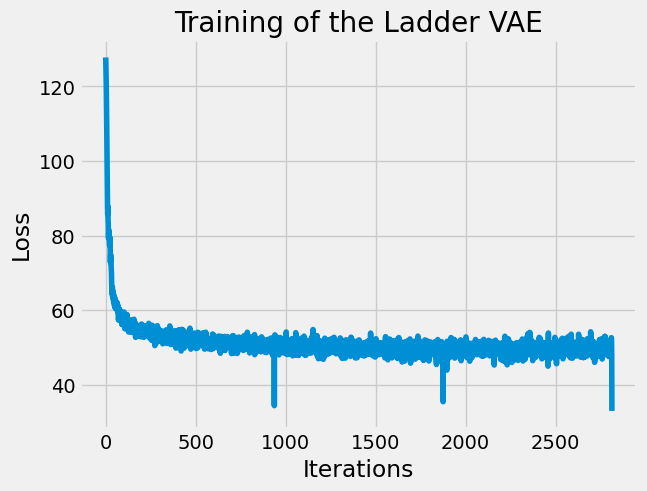

In [5]:
plt.style.use('fivethirtyeight')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title("Training of the Ladder VAE")
plt.plot([t for t in losses])

<Figure size 640x480 with 0 Axes>

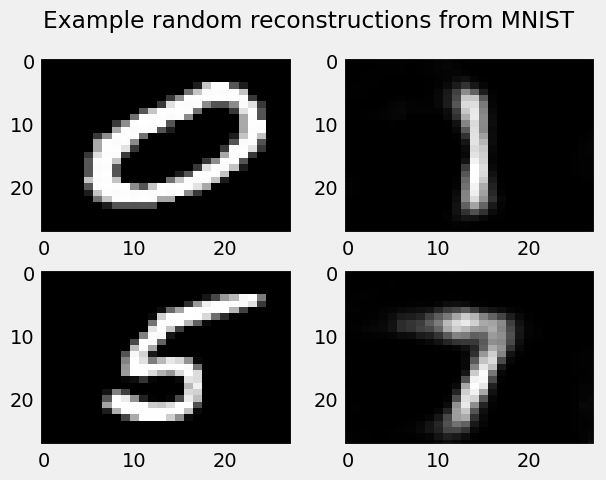

In [10]:
N = 2
plt.figure()
plt.subplots(N, 2)

data = next(iter(loader))[0]

image_batch = data.to(DEVICE) #corrupt(data, device=DEVICE)

model.eval()
with torch.no_grad():
    outputs = model(image_batch)[0]

first_image = image_batch[0, 0, :, :].cpu().numpy()
second_image = image_batch[1, 0, :, :].cpu().numpy()
first_output = outputs[0, 0, :, :].cpu().numpy()
second_output = outputs[1, 0, :, :].cpu().numpy()

plt.subplot(2, 2, 1)
plt.imshow(first_image, cmap='gray', aspect='auto')
plt.grid(False)
plt.subplot(2, 2, 2)
plt.imshow(first_output, cmap='gray', aspect='auto')
plt.grid(False)

plt.subplot(2, 2, 3)
plt.imshow(second_image, cmap='gray', aspect='auto')
plt.grid(False)
plt.subplot(2, 2, 4)
plt.imshow(second_output, cmap='gray', aspect='auto')
plt.grid(False)

plt.suptitle("Example random reconstructions from MNIST")
plt.show()


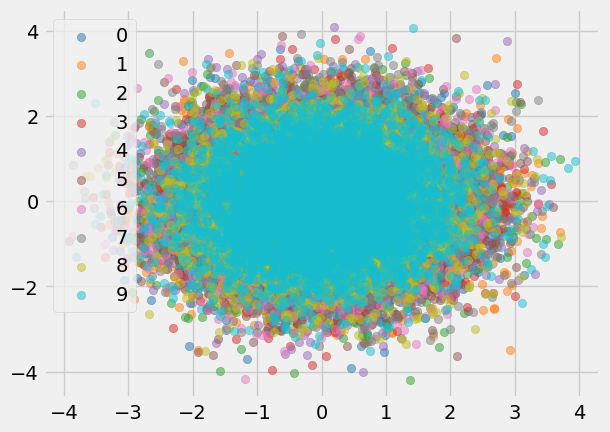

In [11]:
plot_latent_space_with_labels(10, loader, model, DEVICE)
plt.legend()
plt.show()

<Figure size 4000x1000 with 0 Axes>

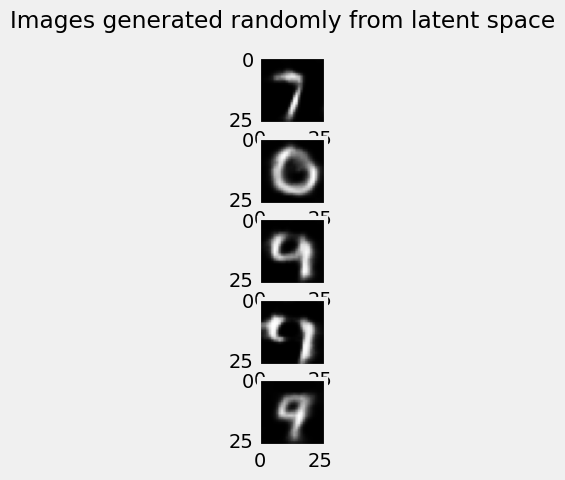

In [17]:
z_ = torch.randn((5, 2), device=DEVICE)

model.eval()
with torch.no_grad():
    outputs = model.decoder(z_).cpu().numpy()
plt.figure(figsize=(40, 10))
plt.subplots(5, 1)

plt.subplot(5, 1, 1)
plt.imshow(outputs[0, 0, :, :], cmap="gray", aspect="equal")
plt.grid(False)
    
plt.subplot(5, 1, 2)
plt.imshow(outputs[1, 0, :, :], cmap="gray", aspect="equal")
plt.grid(False)

plt.subplot(5, 1, 3)
plt.imshow(outputs[2, 0, :, :], cmap="gray", aspect="equal")
plt.grid(False)

plt.subplot(5, 1, 4)
plt.imshow(outputs[3, 0, :, :], cmap="gray", aspect="equal")
plt.grid(False)

plt.subplot(5, 1, 5)
plt.imshow(outputs[4, 0, :, :], cmap="gray", aspect="equal")
plt.grid(False)

plt.suptitle("Images generated randomly from latent space")

plt.show()

<Figure size 4000x1000 with 0 Axes>

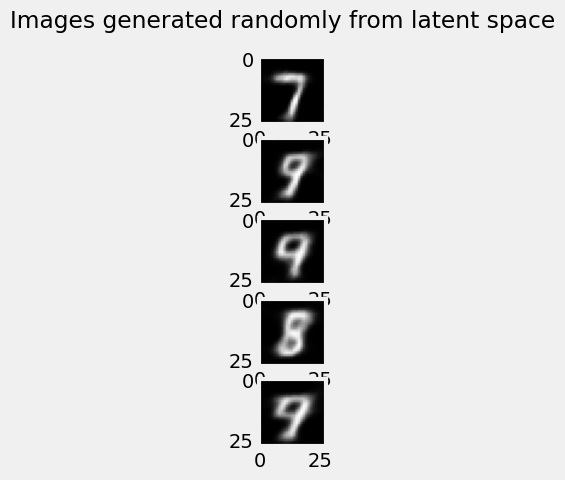

In [20]:
# Generation space is shrinked here
z_ = torch.randn((5, 2), device=DEVICE) * 0.5

model.eval()
with torch.no_grad():
    outputs = model.decoder(z_).cpu().numpy()
plt.figure(figsize=(40, 10))
plt.subplots(5, 1)

plt.subplot(5, 1, 1)
plt.imshow(outputs[0, 0, :, :], cmap="gray", aspect="equal")
plt.grid(False)
    
plt.subplot(5, 1, 2)
plt.imshow(outputs[1, 0, :, :], cmap="gray", aspect="equal")
plt.grid(False)

plt.subplot(5, 1, 3)
plt.imshow(outputs[2, 0, :, :], cmap="gray", aspect="equal")
plt.grid(False)

plt.subplot(5, 1, 4)
plt.imshow(outputs[3, 0, :, :], cmap="gray", aspect="equal")
plt.grid(False)

plt.subplot(5, 1, 5)
plt.imshow(outputs[4, 0, :, :], cmap="gray", aspect="equal")
plt.grid(False)

plt.suptitle("Images generated randomly from latent space")

plt.show()